"""  #    
Bloque de introducci√≥n

"""  #

# Datasets
## Preparaci√≥n
### Librer√≠as

In [3]:
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, cut_tree
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

"""  #    
### Descarga
Preparamos una funci√≥n gen√©rica para la descarga de los datasets y su preparaci√≥n.     
√âsta nos permite escoger los atributos que usaremos, as√≠ como extraer a un variable aparte las clases en caso de estar disponibles.

"""  #


In [4]:
def load_dataset(dataset_url: str, attributes: dict, separator: str = '\s+', class_position: int = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from a text based dataset
    :param dict attributes: attributes to keep in dictionary form:
        key: attribute position, value: attribute name
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
        if left empty (None), no prediction class will be used (intrinsic case).
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Add class index to the indexes to extract.
    if class_position is not None:
        attributes[class_position] = 'classes'

    # Keep only desired attributes and classes.
    dataset = dataset[attributes]

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Do not transform classes.
        if column == class_position:
            continue

        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    dataset.dropna(inplace=True)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset[class_position]
        # Remove classes from attributes.
        dataset.drop(class_position, axis=1, inplace=True)

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    # Set attributes title.
    dataset.rename(columns=attributes, inplace=True)

    return classes, dataset


"""  #    
### Visualizaci√≥n
Usaremos una funci√≥n com√∫n para presentar los datos, tanto si est√°n clasificados como si no.    
Adem√°s, en caso de usar m√°s de dos atributos del dataset, usaremos el *pairplot* de seaborn para presentar los atributos de dos en dos.

"""  #


In [5]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    # Combine all attributes two by two.
    combinations = list(it.combinations(dataset.columns, r=2))
    # Limit the number of plot columns.
    max_cols = 4
    cols = len(combinations) if len(combinations) <= max_cols else max_cols
    # From the columns number, set rows number.
    rows = int(np.ceil(len(combinations) / cols))

    # Calculate plot sizes depending on subplots number.
    size_x = int(13 * cols / max_cols) + 7
    size_y = 6 if rows * cols == 1 else 5 * rows

    # Build up all subplot combinations.
    fig, ax = plt.subplots(rows, cols, figsize=(size_x, size_y))
    for key, pair in enumerate(combinations):
        # Calculate plot axis position from sub-plot key.
        column = key % cols
        row = int(key / cols) % rows
        # Position needs to be a list when multiple rows.
        position = column if rows == 1 else (row, column)
        # Ax is not an array when single row and column.
        subplot = ax if rows * cols == 1 else ax[position]

        # Plot attributes values and titles.
        subplot.scatter(dataset[pair[0]], dataset[pair[1]], c=classes)
        subplot.set_title(str(pair[0]) + ' / ' + str(pair[1]))


## M√©tricas
### M√©tricas extr√≠nsecas

In [6]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real == cats[i], cat_pred == clusts[j]))
                     for j in np.arange(clusts.size)]
                    for i in np.arange(cats.size)])
    return (mat)


In [7]:
def medida_error(mat):
    assign = np.sum([np.max(mat[l, :]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))


def medida_precision(mat, l, k):
    return mat[l, k] / sum(mat[:, k])


def medida_recall(mat, l, k):
    return mat[l, k] / sum(mat[l, :])


def medida_pureza(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    return np.sum([
        totales[k] * np.max(mat[:, k] / float(np.sum(mat[:, k])))
        for k in np.arange(mat.shape[1])
    ])


In [8]:
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec + rec) == 0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)


def medida_f1(mat):
    totales = np.sum(mat, axis=1) / float(np.sum(mat))
    assign = np.sum([
        totales[l] * np.max([
            medida_f1_especifica(mat, l, k)
            for k in np.arange(mat.shape[1])
        ])
        for l in np.arange(mat.shape[0])
    ])
    return assign


In [9]:
def medida_entropia(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    relMat = mat / np.sum(mat, axis=0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat == 0] = 0.0001  # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([
        totales[k] * np.sum([
            relMat[l, k] * logRelMat[l, k]
            for l in np.arange(mat.shape[0])
        ])
        for k in np.arange(mat.shape[1])
    ])


"""  #     
####  Agrupaci√≥n m√©tricas extr√≠nsecas
La funci√≥n a continuaci√≥n nos permite generar un diccionario con todas las m√©tricas intr√≠nsecas y poder compararlas entre algoritmos.

"""  #


In [10]:
def calculate_extrinsic_metrics(real_classes, predicted_classes):
    confusion_matrix = matriz_confusion(real_classes, predicted_classes)

    return {
        'Error': medida_error(confusion_matrix),
        'Pureza': medida_pureza(confusion_matrix),
        'F1': medida_f1(confusion_matrix),
        'Entrop√≠a': medida_entropia(confusion_matrix),
        'Informaci√≥n m√∫tua': metrics.mutual_info_score(real_classes, predicted_classes)
    }


"""  #    
### M√©tricas intr√≠nsecas
A√±adimos las funciones de c√°lculo de m√©tricas intr√≠nsecas no disponibiles directamente en python o al menos en sklearn.

"""  #


In [11]:
def RMSSTD_score(dataset, prediction, centers):
    # Extract all individual predicted classes.
    labels = np.unique(prediction)

    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centers[label], axis=1) ** 2)
        for label in labels
    ])

    denominator = dataset.shape[1] * np.sum([
        np.sum(prediction == label) - 1
        for label in labels
    ])

    return np.sqrt(numerator / denominator)


In [12]:
def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R¬≤ score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator


In [13]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


def distance_matrix(X, distancia):
    mD = np.zeros((X.shape[0], X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0], :], X[pair[1], :])
    return mD


def medida_I(dataset, prediction, centers, distance_function, p=1):
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    distance_max = np.max(distance_matrix(centers, distance_function))

    num = np.sum([distance_function(instance, attributes_mean) for instance in dataset.values])

    den = len(labels) * np.sum([
        np.sum([
            distance_function(dataset.iloc[i], centers[k])
            for i in np.arange(dataset.shape[0])[prediction == labels[k]]
        ])
        for k in np.arange(centers.shape[0])
    ])

    return (num / den * distance_max) ** p


"""  #    
####  Agrupaci√≥n m√©tricas intr√≠nsecas
La siguiente funci√≥n nos permite generar un diccionario con todas las m√©tricas intr√≠nsecas y poder compararlas entre algoritmos.

"""  #


In [14]:
def calculate_intrinsic_metrics(dataset, prediction):
    return {
        # 'RMSSTD': RMSSTD_score(dataset, model['prediction'], model['centers']),
        # 'R¬≤': r2_score(dataset, model['prediction'], model['centers']),
        'Silueta': metrics.silhouette_score(dataset, prediction),
        'Calinski Harabasz': metrics.calinski_harabasz_score(dataset, prediction),
        # 'Medida I': medida_I(dataset, model['prediction'], model['centers'], distancia),
        'Davies Bouldin': metrics.davies_bouldin_score(dataset, prediction)
    }


## Selecci√≥n

"""  #    
### Dataset extr√≠nseca
   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)

**Number of Instances:** 398

**Number of Attributes:** 9 including the class attribute

**Attribute Information:**

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

"""  #

In [15]:
# Cargamos el dataset.
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
attributes = {0: 'mpg', 2: 'displacement', 3: 'horsepower', 4: 'weight', 5: 'acceleration'}
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, attributes, class_position=1)

# Soporte para las m√©tricas
extrinsic_metrics = {}

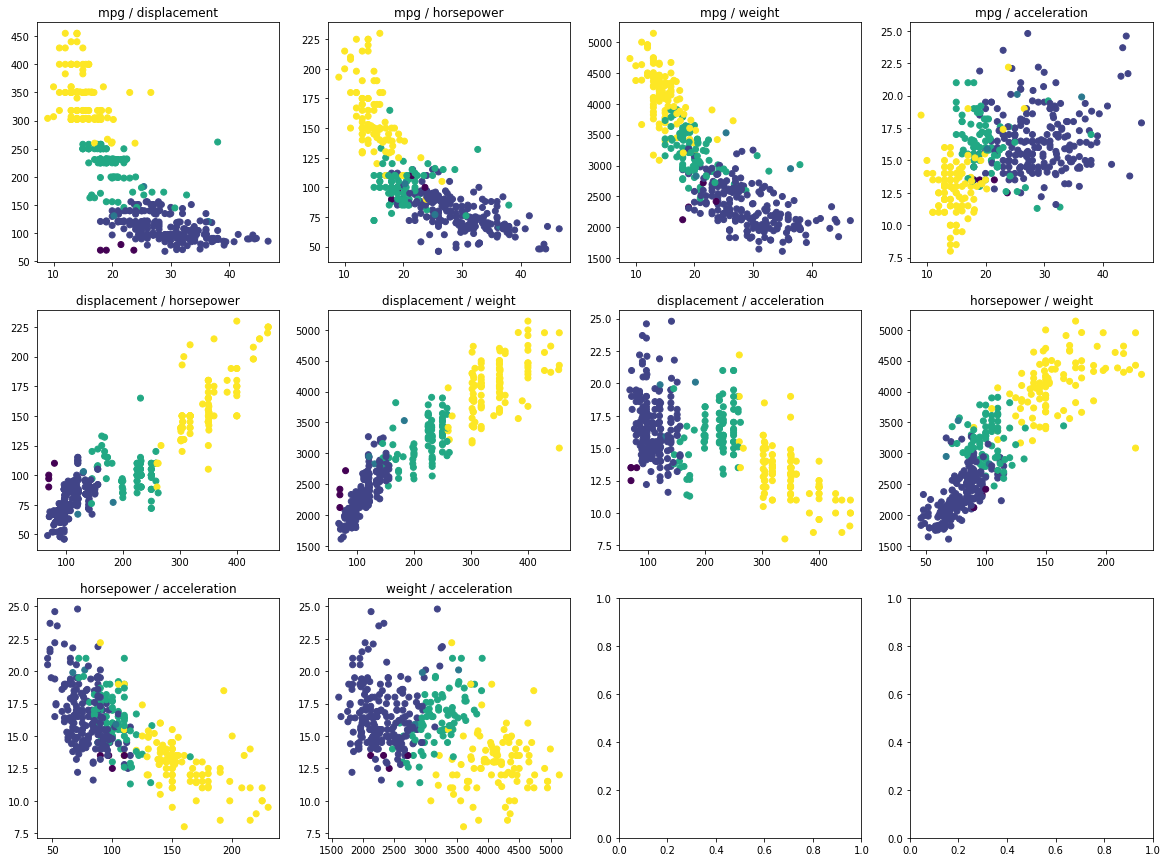

In [152]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

"""  #    
blablabla

"""  #

"""  #    
## Dataset intr√≠nseca
El dataset intr√≠nseca **Aggregations** est√° generado de manera artificial por: *A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007*


Este dataset est√° compuesto por 788 observaciones de 2 variables que abarcan un amplio rango num√©rico. En el conjunto de datos existen entre 5 a 7 grupos que se distribuyen en zonas particulares del rango de valores de las variables.


Cargamos nuestro dataset (*intrinsic_dataset*):

"""  #

In [16]:
# Cargamos el dataset.
dataset_url = 'http://cs.joensuu.fi/sipu/datasets/Aggregation.txt'
attributes = {0: 'dim 1', 1: 'dim 2'}
_, intrinsic_dataset = load_dataset(dataset_url, attributes)

# Soporte para las m√©tricas
intrinsic_metrics = {}

"""  #    
Visualizamos el dataset en 2-D.

"""  #

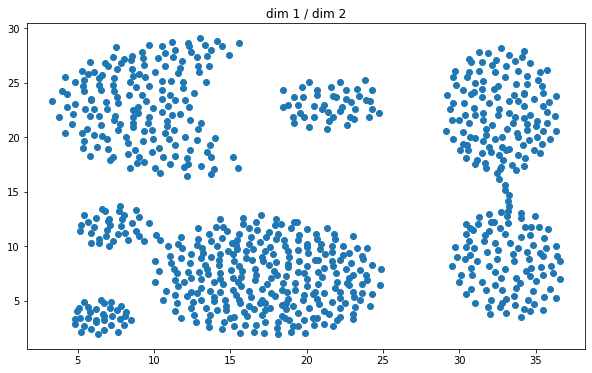

In [17]:
plot_dataset(intrinsic_dataset)

"""  #    
Observando las caracter√≠sticas de esta representaci√≥n, podemos decir que es un conjunto de datos compacto, lo que nos permitir√° obtener resultados aceptables con con algoritmos de agrupamiento K-means y jer√°rquicos, y parece que se podr√≠a clasificar con 4, 5 o con 7 clusters.

"""  #

"""  #    
# Algoritmos
Preparamos funciones 'herramienta' para cada algoritmo para poder analizarlos.

"""  #

## K-Means

"""  #    
M√©trica R cadrado. No usamos directamente la de sklean al √©sta necesitar la clases reales.
Esta m√©trica nos permite valorar el ratio de distancia intracl√∫ster con respecto a la distancia intercl√∫ster.

"""  #

"""  #    
Funci√≥n para generar gr√°ficamente la evoluci√≥n de las m√©tricas R¬≤ y Silueta seg√∫n el n√∫mero de cluters, de forma a escoger el n√∫mero de clusters √≥ptimo, usando la t√©cnica del codo.

"""  #


In [18]:
def kmeans_plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("N√∫mero de cl√∫steres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("N√∫mero de cl√∫steres")
    ax[1].set_ylabel("Medida de R cuadrado")


# An√°lisis dataset extr√≠nseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selecci√≥n del n√∫mero de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad √≥ptima de centroides a utilizar a partir del M√©todo del Codo.

"""  #

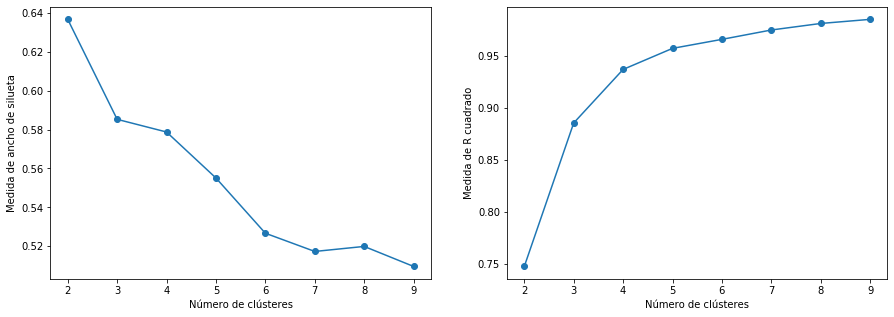

In [19]:
kmeans_plot_clusters_selection(extrinsic_dataset)

"""  #    
Vemos un "codo" pronunciando con 4 clusters, pero el ancho de silueta es "m√≠nimo" a partir de 6 clusters.     
Escogemos 5 clusters como punto intermedio.

"""  #

#### Ejecuci√≥n del algoritmo

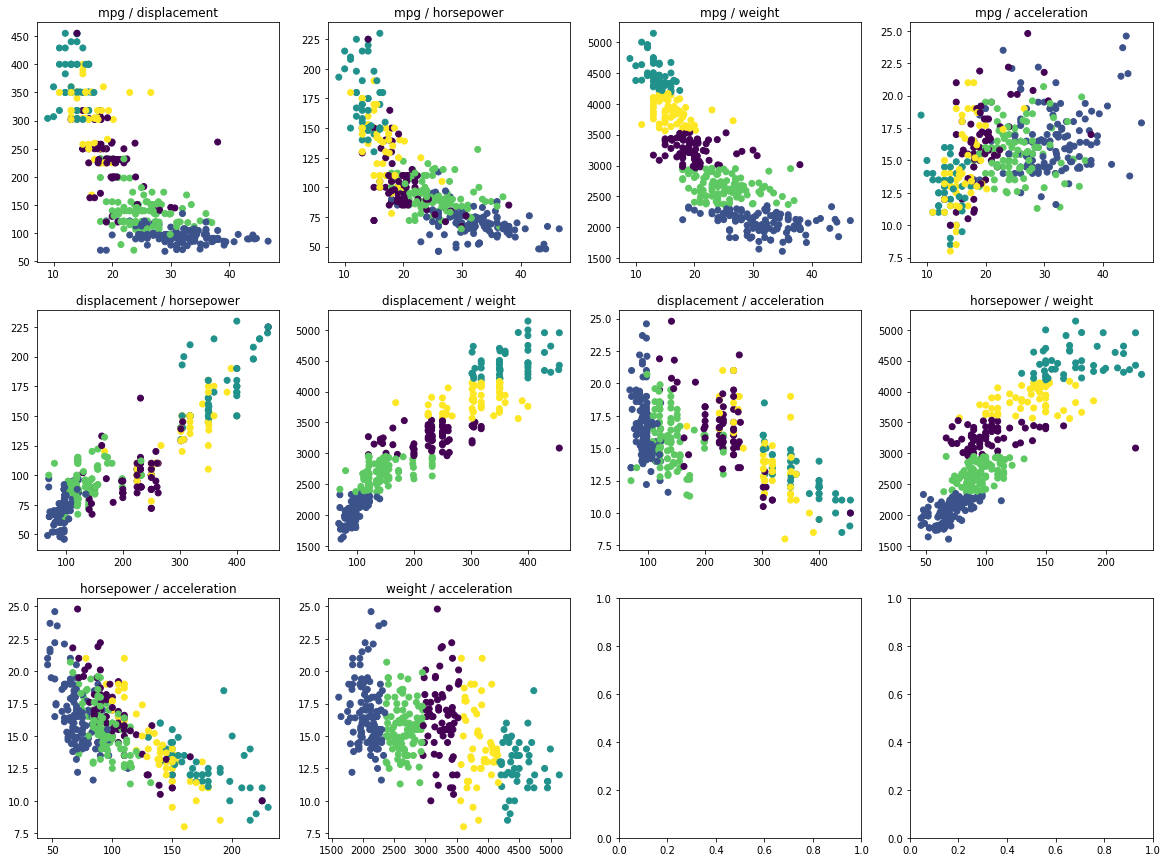

In [20]:
model = KMeans(n_clusters=5).fit(extrinsic_dataset)
prediction = model.predict(extrinsic_dataset)
extrinsic_metrics['k-means'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

plot_dataset(extrinsic_dataset, prediction)

"""  #     
blablabla

"""  #

### Algoritmo Jer√°rquico Aglomerativo
#### Ejecuci√≥n del algoritmo

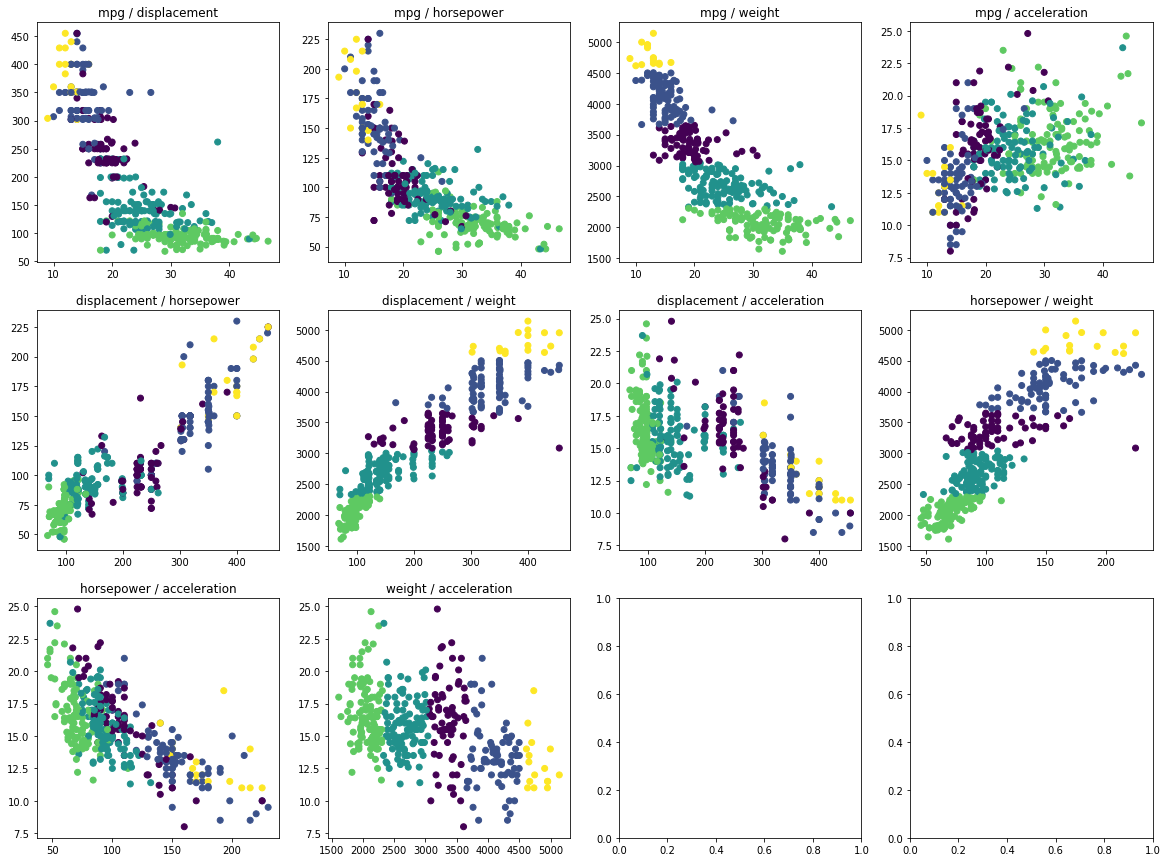

In [21]:
# Generamos el modelo.
model = linkage(extrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=5).flatten()
# Guardamos la m√©tricas.
extrinsic_metrics['Jer√°rquico'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Algoritmo Agrupamiento espectral

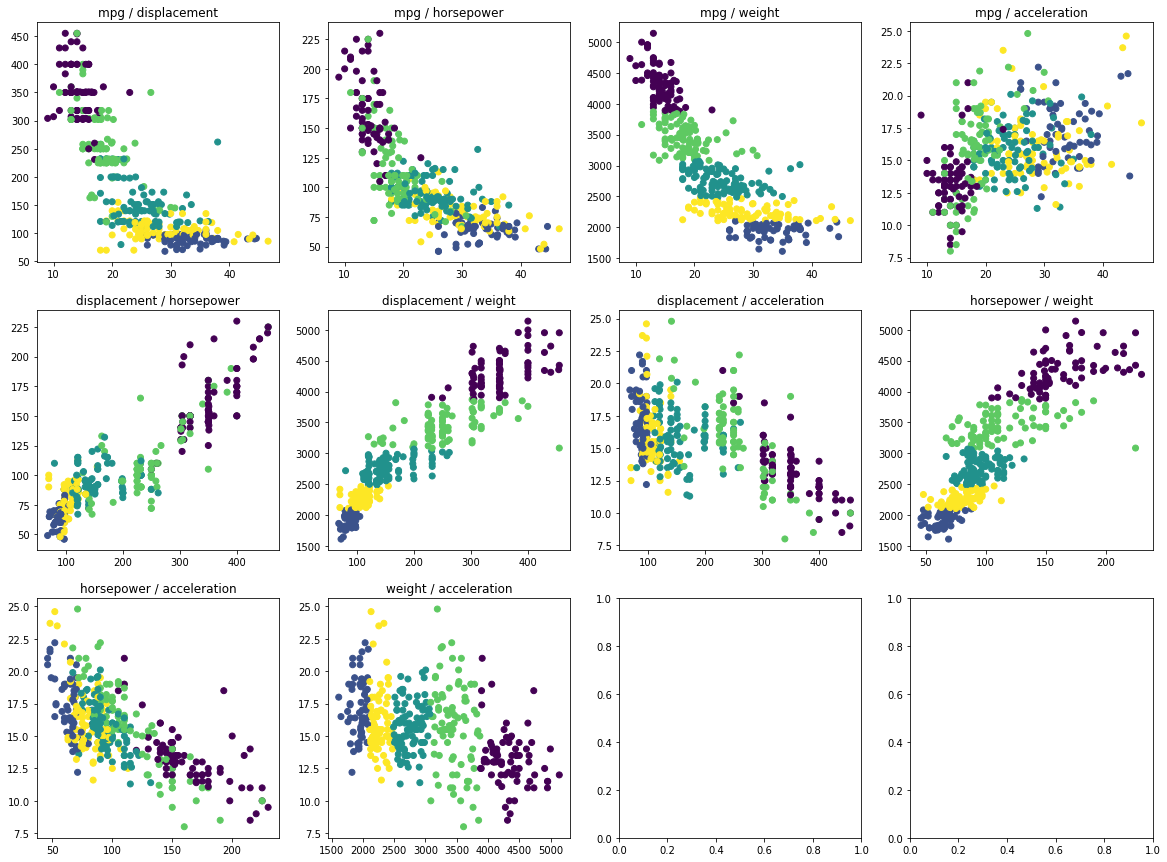

In [22]:
K = 5
knn = 50

# Generamos el modelo.
model = SpectralClustering(
    n_clusters=K, affinity='nearest_neighbors', n_neighbors=knn, random_state=0
).fit(extrinsic_dataset)
prediction = model.labels_

# Guardamos la m√©tricas.
extrinsic_metrics['Espectral'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Algoritmo Mean Shift

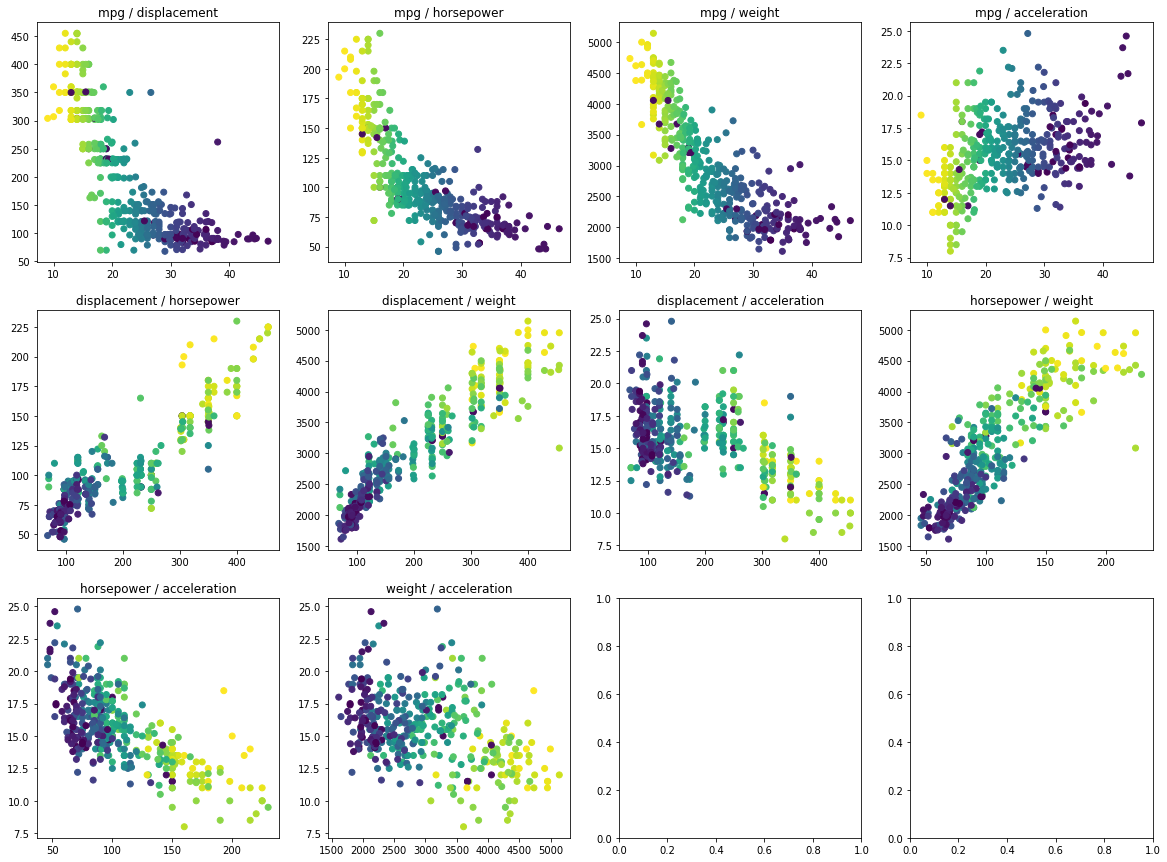

In [24]:
h = 6

# Generamos el modelo.
model = MeanShift(bandwidth=h).fit(extrinsic_dataset)
prediction = model.labels_

# Guardamos la m√©tricas.
extrinsic_metrics['Means-Shift'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Algritmo EM

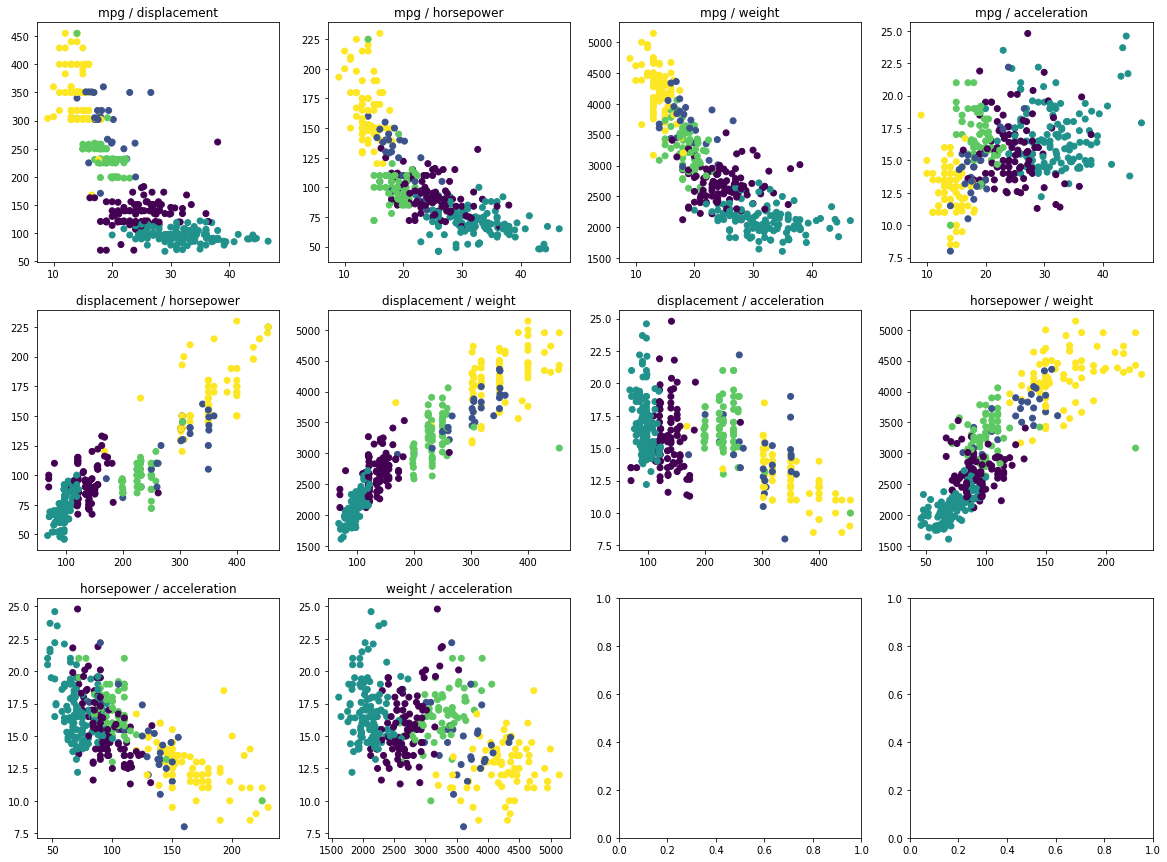

In [25]:
# Generamos el modelo.
model = GaussianMixture(n_components=5, max_iter=1000).fit(extrinsic_dataset)
prediction = model.predict(extrinsic_dataset)

# Guardamos la m√©tricas.
extrinsic_metrics['EM'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Comparaci√≥n algoritmos

In [26]:
display(pd.DataFrame(extrinsic_metrics))

k-means  Jer√°rquico  Espectral  Means-Shift        EM
Error              0.438776    0.385204   0.479592     0.979592  0.311224
Pureza             0.844388    0.836735   0.803571     1.000000  0.918367
F1                 0.681919    0.715776   0.619414     0.037984  0.790758
Entrop√≠a           0.430737    0.440150   0.452793    -0.000000  0.267533
Informaci√≥n m√∫tua  0.677388    0.667975   0.655333     1.108125  0.840592

"""  #    
blabla comparaci√≥n dataset extrinseca

"""  #

# An√°lisis dataset intr√≠nseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selecci√≥n del n√∫mero de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad √≥ptima de centroides a utilizar a partir del M√©todo del Codo.

"""  #

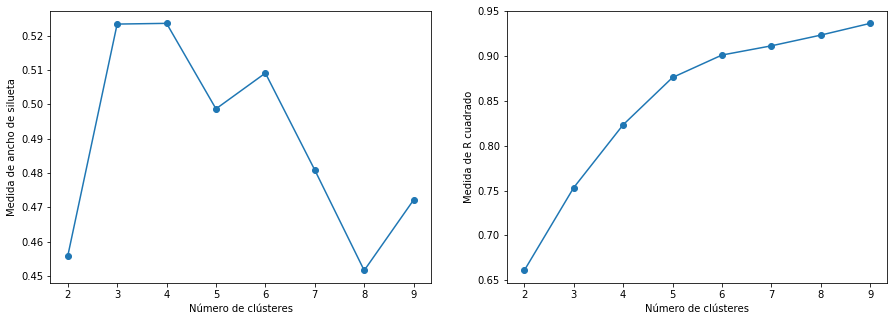

In [27]:
kmeans_plot_clusters_selection(intrinsic_dataset)

"""  #    
Seg√∫n el procedimiento del codo, escoger√≠amos entre 5 y 7 clusters

"""  #

"""  #
#### Ejecuci√≥n del algoritmo
Ejecutamos la predicci√≥n de k-means con 5 clusters y visualizamos la agrupaci√≥n generada.


"""  #

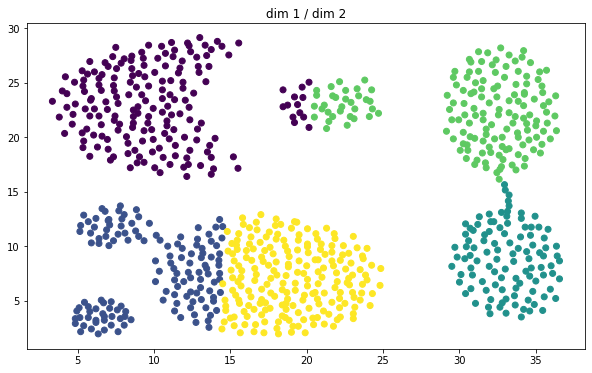

In [37]:
# Generamos el modelo.
model = KMeans(n_clusters=5).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)

# Guardamos la m√©tricas.
intrinsic_metrics['k-means'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

"""  #    
Vemos que mientras se han logrado aislar algunos grupos, otros claramente se han quedado a medias.

"""  #

### Algoritmo Jer√°rquico Aglomerativo

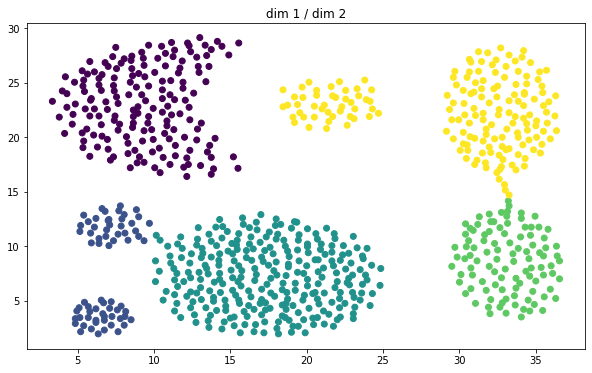

In [30]:
model = linkage(intrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=5).flatten()
intrinsic_metrics['Jer√°rquico'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

### Algoritmo Agrupamiento espectral

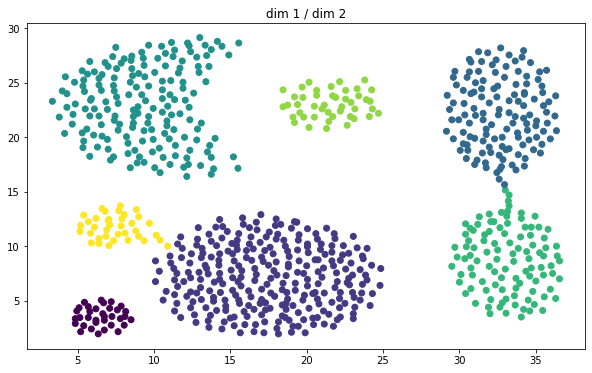

In [41]:
K = 7
knn = 34
model = SpectralClustering(
    n_clusters=K, affinity='nearest_neighbors', n_neighbors=knn, random_state=0
).fit(intrinsic_dataset)
prediction = model.labels_
intrinsic_metrics['Espectral'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

"""  #    
El jerarquico con 30 KNN resuelve bien la clusterizaci√≥n con 7 grupos, si se reduce no lo hace tan bien, y  partir de 50 tampoco. Hay que encontar el valor correcto.    
Buscando 5 clusters tambien lo hace bien.

"""  #

### Algoritmo Mean Shift

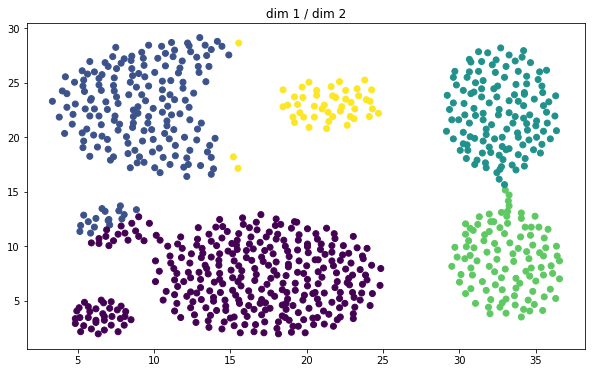

In [44]:
h = 6
model = MeanShift(bandwidth=h).fit(intrinsic_dataset)
prediction = model.labels_
intrinsic_metrics['Means-Shift'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

### Algoritmo EM

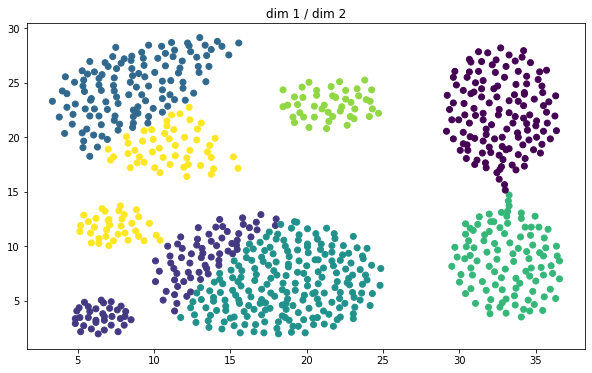

In [55]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=7, max_iter=1000).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)
intrinsic_metrics['EM'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

"""  #    
Este a veces la clava y a veces no. Hay que darle varias veces. Es curioso.

"""  #

### Comparaci√≥n algoritmos

In [56]:
display(pd.DataFrame(intrinsic_metrics))

k-means   Jer√°rquico    Espectral  Means-Shift  \
Silueta               0.498698     0.500799     0.495873     0.520544   
Calinski Harabasz  1326.047590  1208.002199  1218.664345  1081.305595   
Davies Bouldin        0.704203     0.682380     0.509633     0.556957   

                            EM  
Silueta               0.445468  
Calinski Harabasz  1205.280137  
Davies Bouldin        0.785877

"""  #     
Seg√∫n el **coeficiente de silueta** tanto con el *Jer√°rquico* como con el *Means-Shift* obtenemos muestras m√°s separadas de otros cl√∫sters vecinos. Pero los valores en el resto de algoritmos son bastante parecidos, y por tanto no es una caracter√≠stica claramente diferenciadora.

Sin embargo, el indicador **Calinski-Harabasz** que relaciona la cohesi√≥n y separaci√≥n de la siguiente forma: $\frac{ùëÜùëÜùêµ/(ùëò‚àí1)}
{ùëÜùëÜùëä/(ùëõ‚àíùëò)}$, nos da como mejor resultado de clasificaci√≥n el obtenido con el algoritmo *K-Means*, seguido del *Espectral*.

Finalmente el √≠ndice **Davies Bouldin**, se√±ala al *Espectral* como el mejor agrupamiento, esto es debido a que se mide la proporci√≥n entre la suma de la dispersi√≥n dentro del cl√∫ster a la separaci√≥n entre cl√∫sters, y por tanto apremia a resultados de agrupamiento en los que no tienen por qu√© ser similares los grupos entre si.

"""  #

# Conclusi√≥n